# Baggage handler (rampie) route optimization in an airport departure operation

## Description:
A heuristic goal programming, binary LP built using Gurobi/Python that picks best gate route from pareto solution pool to reduce flight delay due to baggage delivery at finite number of departure gates by a baggage handling vehicle which tows finite number of carts in an airport operation.


## Background:

The airline management often requires sophisticated and complex mathematical models to operate even the most mundane tasks that could be executed with very less thought as it results in a huge cost savings during the operation. One such operations is carried out by a Rampie. A Rampie is the driver of a baggage runner vehicle that tows variable number of carts depending on the airline departure schedule and traffic, which delivers baggage to its corresponding airline gate from the central bag repository. The bags of the passengers after being handed over at the check-in counter reach via an automated conveyor system a specified spot in the central baggage room from where they get picked by the rampie.<br>

**Challenge:** The rampie often faces a situation where there would be multiple flights waiting for baggage and they would be having departure deadlines very close to each other and choosing between which baggage to pick in to cart first and first stop of delivery is extremely sensitive and even a slight deviation from the optimal delivery would lead to huge delays in flight departures and adding to it the irony of having no clue about what the optimal solution is in the first place. Designing an Operations Research mathematical model to find this optimal delivery sequence is very demanding in the airline industry and also very challenging.<br>

In an airline industry, passenger experience and feedback play a very crucial role in its potential to dominate the market. In this exercise a very similar problem statement has been setup in a much simpler way and a solution approach has been proposed.<br>

**Problem statement:** Considering an airport operation where the airline company has been allotted gates 1 to 9 to operate their departure business. Flights ready to take off from all these 9 gates are waiting for their baggage to get delivered by the rampie. The departure times of these flights are scheduled as shown in the below table. The rampie could tow 4 carts at a time and each cart has enough space to load baggage of a single gate. No cart can be loaded with baggage belonging to multiple gates but only a single gate. For simplicity assuming the central baggage room is located at the very beginning of the gate line and each gate is located in a linear layout with equal distances from their neighboring gates as depicted in picture below. Assuming loading and unloading time is 5 minutes and 2 minute to travel from a gate to its neighboring gate, the goal is to find out the best sequence of delivery that minimizes delay in gates due to delay in delivery (if any).


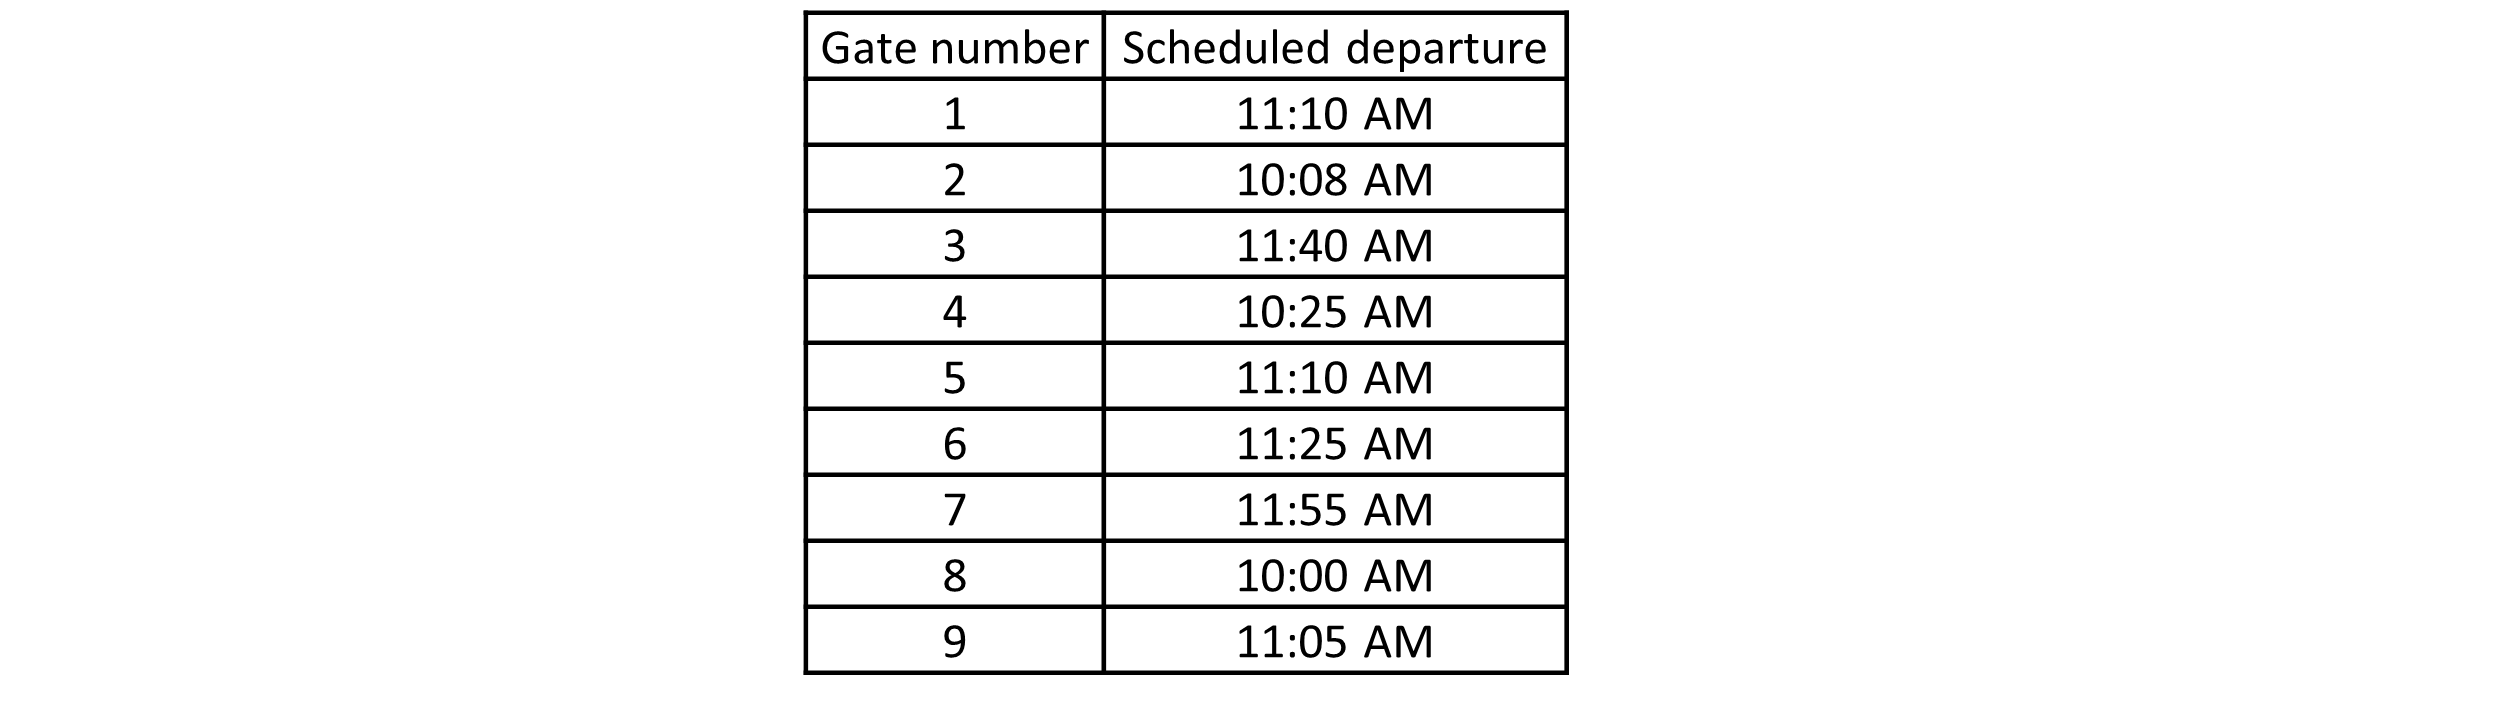

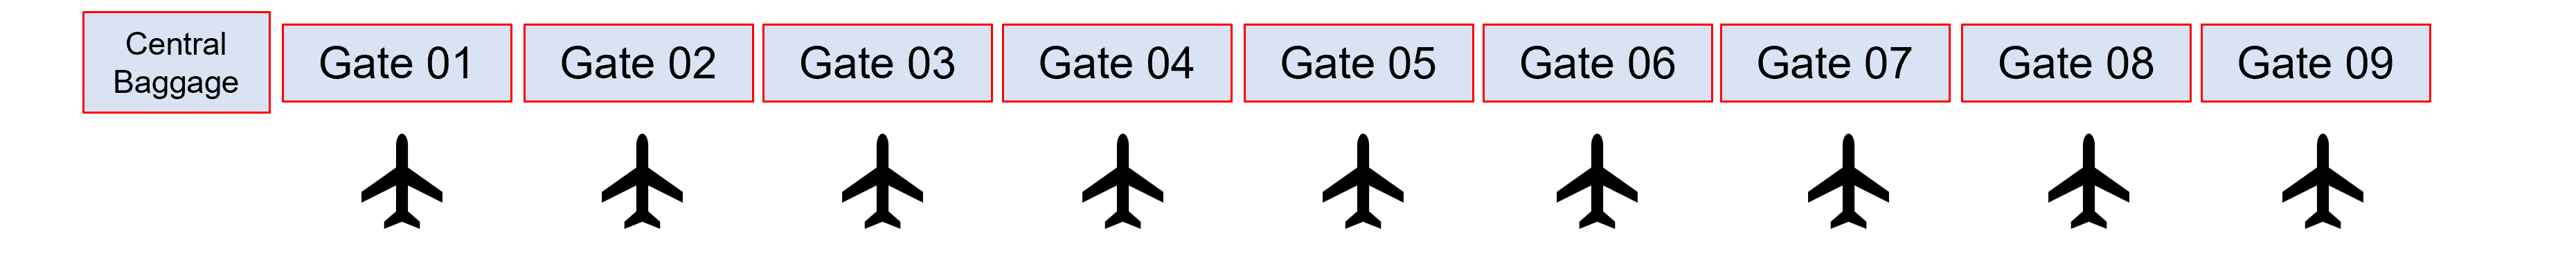

## Result format

As this repository is being public, I would like to conceal the reasoning,logic of the constraint developement, however, the mathematical form is shown in code.<br>

The final result is produced in a tabular format as shown in the below example. Starting from the left, "attempt 0" describes the initial move/action taken by the rampie, indeed picks(p) bags belonging to gates-(2,5,8,9) which happens only at gate-(0)/central baggage room and the next move "attempt 1" is made to drop(d) baggage belonging to gate-(2) and the next one dropped(d) at gate-(8). "attempt 3" again shows the rampie moving to central baggage room to pick(p) baggages of gates-(6,7).The final attempt/move made was during "attempt 12" where baggage to gate-(4) has been delivered. 0d indicates that those atempts were not used and final delivery was accomplished before reaching to that attempt<br>

"total_time" indicates how many hours it took for the rampie to finish delivery to all gates and "sequence" shows the same route performance in a string format.

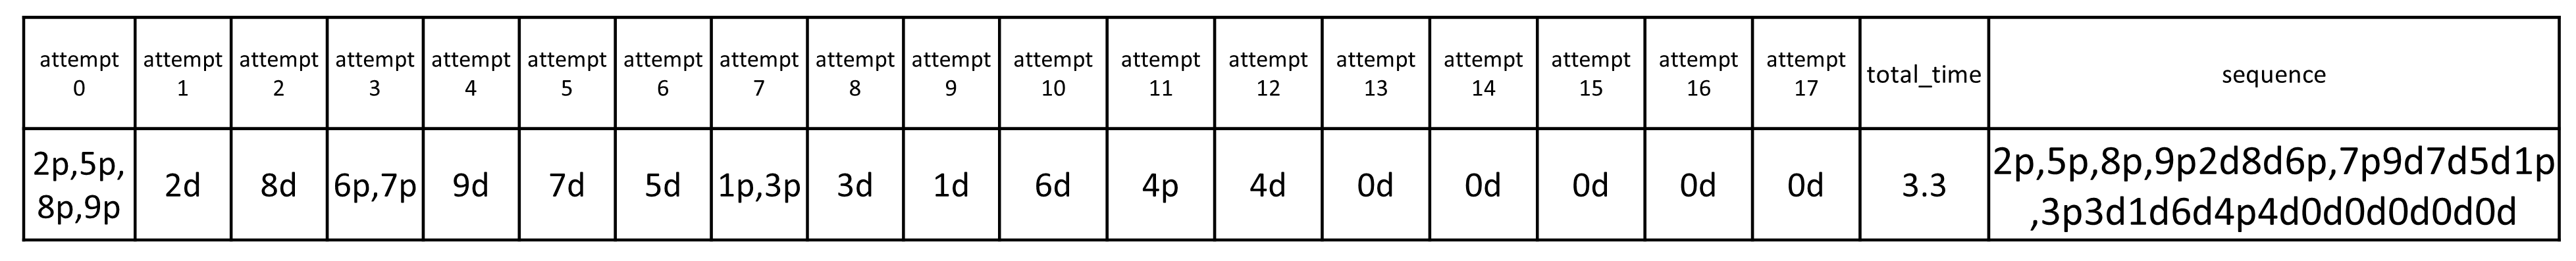

## Heuristic optimization approach

The objective of the model is to make sure that all gates receive their baggage on time or with least delay possible. It would be much easier to write an objective function that minimizes the total working time of the ramper vehicle, but it only favors the rampie to leave work and go home early rather than focusing on delays caused at the gates. To be precise, there would exist two different paths that have the same total travel time but only one of those paths might be able to deliver baggage on time at all gates while the other might not.
When trying to minimize total delays at each gate, there would be a trade off in delivery delays within gates. In that case it would be difficult to choose one over the other as we have no specific goal to look for, hence named this model a goal programming model.

A heuristic approach using Pareto feasible solution pool 
The usual way of solving a goal programming formulation is by setting weights/penalties to different objectives and concatenate into one final objective function, however, I have decided to approach this problem in an unusual way.

Pareto optimal solutions are those solutions within the decision space whose corresponding variables cannot be all simultaneously improved. I would first print out all possible combinations of solutions using Gurobi just based on constraints; and by setting a dummy objective function in the code. This would give me a pool of solutions that the rampie could choose from and out of this pool of solutions I would filter out for those solutions that have no delay at any of the gates.
If such solutions exist, I will then choose the one with least total job time. If such solutions do not exist, it means that a perfect delivery with no delay at any of the gates is impossible for that situation. If there exist only solutions of such kind in the pool, the best way of approach that one might think is to choose the one having least number of gates delivered with delay (each with some amount of delay) and among them again choose the one with least total job time.

However, choosing the solution with least number of delayed gates poses a caveat. Suppose if we pick a solution with only one gate say gate-6 delayed by an hour and others delivered on time, one will rather wish for a solution that observes a 10-minute delay at 5 gates which compensates for gate-6 delay, i.e., just a 10 min delay at gate-6 as well.
In order to promote such compensations, I will choose a delay threshold allowing no gate to delay beyond that threshold and choose among the solutions filtered based on this threshold value, the one with least number of gates delivered with a delay. If failed to find a solution, I would then increase the threshold by some small value (say 30 seconds) and repeat the process again until a solution has been found.

A final way of approach to choosing the solution is explained in the pseudo flow chart as shown below.



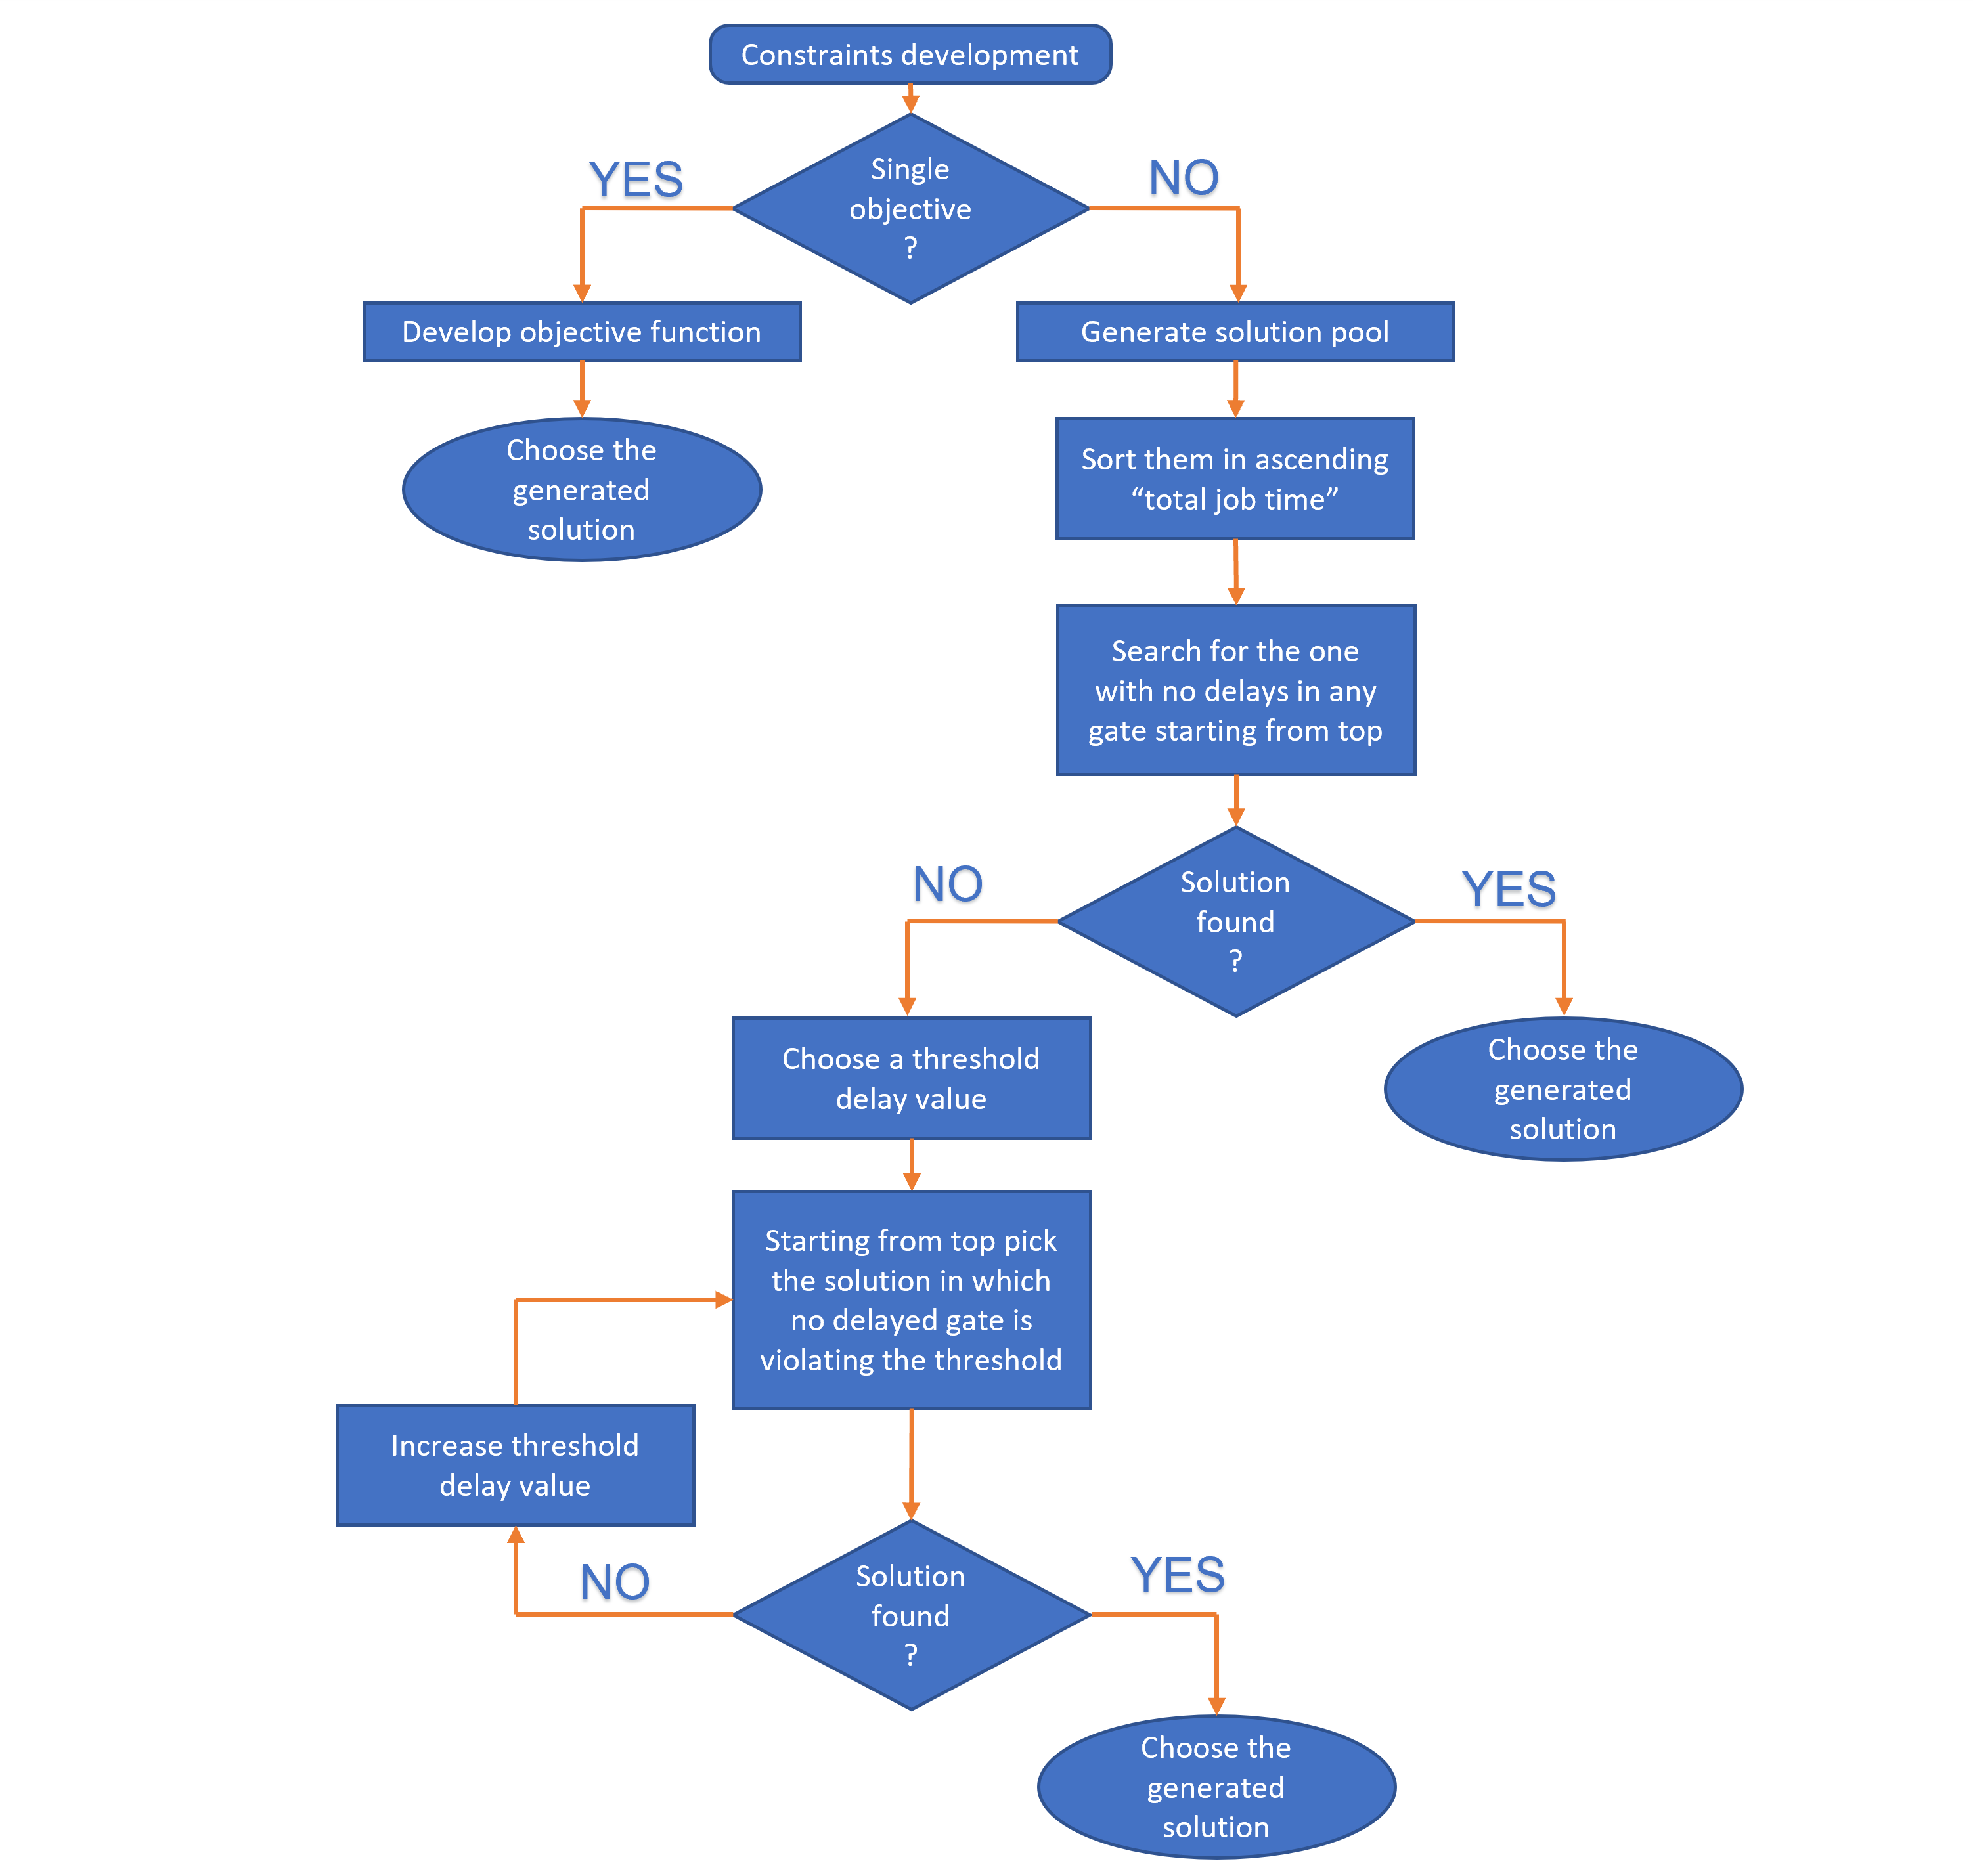

## A major flaw during the execution

In this Jupyter notebook the depicted algorithm has not been put to use and in fact, no solution has been produced due to having found a major flaw with the solution pool. Hence, the solution selection has been halted for now and still working on resolving the issue.<br> 
### The flaw: 
**Not every possible combination of feasible solution is produced in the solution pool.**<br>
Expectation: Due to the objective function being a dummy value, Gurobi has no final value to look for and Gurobi’s branching has been progressed only with certain combination of variable assignments and produced every possible feasible solution into the pool with those certain combinations. In fact, when tested a missing solution by assigning it as a constraint, the solver did not show an infeasibility status, which proves that the missing solution is a valid feasible solution and should not have been missed in the pool.


In [1]:
# Importing libraries

from gurobipy import *

import numpy as np

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [27]:
m = Model();

In [3]:
# Static parameters
number_of_gates = 9
number_of_carts = 4

# Process parameters in seconds
unload_time = 300
load_time = 300
travel_time = 120

## Defining sets

### Basic sets

$\begin{gather}
I = 0,1, \dots, (number\;of\;gates)\\
J = 0,1, \dots, ((number\;of\;gates\;\times\;2)\;-1)\\
K = 0,1, \dots, ((number\;of\;gates\;\times\;2)\;-2)\\
\end{gather}$

In [4]:
set_I = [I for I in range(0,number_of_gates+1)] # I ---> 0 to 9
set_J = [J for J in range(0,number_of_gates*2)] # J ---> 0 to 17
set_K = [K for K in range(0,number_of_gates*2-1)] # K ---> 0 to 16

### Subsidiary sets

$\begin{gather}
i = 1,2 \dots, (number\;of\;gates)\\
j = 1,2 \dots, ((number\;of\;gates\;\times\;2)\;-1)\\
k = 1,2 \dots, ((number\;of\;gates\;\times\;2)\;-2)\\
\end{gather}$

In [5]:
set_i = [i for i in range(1,number_of_gates+1)] # i --> 1 to 9
set_j = [j for j in range(1,number_of_gates*2)] # j ---> 1 to 17
set_k = [k for k in range(1,number_of_gates*2-1)] # k ---> 1 to 16

## Defining variables

$ x_{J,I} $: $\begin{gather} 1\;If\;the\;rampie\;delivers\;baggage\;belonging\;to\;gate\;I\;in\;J^{th}\;attempt.\;Else\;0 \end{gather}$

$ t_{K,I} $: $\begin{gather} 1\;If\;the\;rampie\;picks\;baggage\;belonging\;to\;gate\;I\;in\;J^{th}\;attempt.\;Else\;0 \end{gather}$

In [6]:
x = m.addVars(set_J, set_I, name="x", lb = +0.0, vtype=GRB.BINARY)
t = m.addVars(set_K, set_I, name="t", lb = +0.0, vtype=GRB.BINARY)

## Defining constraints

$$ \begin{aligned}
\quad&\sum_{K=0}^{(number\;of\;gates\;\times\;2)-2}t_{K,0} = (number\;of\;gates\;\times\;2)-1\\
\forall \; i \in Set\;i \quad&\sum_{K=0}^{(number\;of\;gates\;\times\;2)-2}t_{K,i} = 1\\
\forall \; K \in Set\;K \quad&\sum_{I=0}^{(number\;of\;gates)}t_{K,I} = (number\;of\;carts)+1\\
\end{aligned} $$

In [7]:
m.addConstrs(      (    sum(t[K,a] for K in set_K) == number_of_gates*2-1 for a in [0]   )         ,"con1.1");
m.addConstrs(      (    sum(t[K,i] for K in set_K) == 1 for i in set_i    )         ,"con1.2");
m.addConstrs(      (    sum(t[K,I] for I in set_I) <= number_of_carts+1 for K in set_K   )         ,"con1.3");

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; i \in Set\;i \quad&\sum_{J=0}^{(number\;of\;gates\;\times\;2)-1} x_{J,i} = 1\\
\forall \; J \in Set\;J \quad&\sum_{I=0}^{(number\;of\;gates)} x_{J,I} = 1\\
\end{aligned} $$

In [8]:
m.addConstrs(      (    sum(x[J,i] for J in set_J) == 1 for i in set_i   )         ,"con2.1");
m.addConstrs(      (    sum(x[J,I] for I in set_I) <= 1 for J in set_J   )         ,"con2.2");

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; j \in Set\;j\;\;\;\forall \; i \in Set\;i\quad&x_{j,i}\;-\;\sum_{K=0}^{(j^{th}\;element\;in\;Set\;K)} t_{K,i} \leqslant 0\\
\end{aligned} $$

In [9]:
m.addConstrs(      (    x[j,i] - sum(t[K,i] for K in set_K[:j]) <= 0 for i in set_i for j in set_j   )         ,"con3.1");

-----------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; K \in Set\;K\quad&x_{j,i}\times (Number\;of\;gates)\;-\;\sum_{i=1}^{(Number\;of\;gates)} t_{K,i} \geqslant 0\\
\forall \; K \in Set\;K\quad&(Number\;of\;gates)-1\geqslant x_{j,i}\times (Number\;of\;gates)\;-\;\sum_{i=1}^{(Number\;of\;gates)} t_{K,i} \\
\end{aligned} $$

In [10]:
m.addConstrs(      (     number_of_carts*x[K,0] - sum(t[K,i] for i in set_i) >= 0 for K in set_K   )         ,"con4.1");

# m.addConstrs(      (     number_of_carts > number_of_carts*x[K,0] - sum(t[K,i] for i in set_i) for K in set_K   )         ,"con4.2")
# The above constraint gave me "No implementation error" for some reason of using > instead of >=

m.addConstrs(      (     number_of_carts-1 >= number_of_carts*x[K,0] - sum(t[K,i] for i in set_i) for K in set_K   )         ,"con4.2");

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; k \in Set\;k \quad&\sum_{K=0}^{((k+1)^{th}\;element\;in\;set\;K)}\sum_{i=1}^{(Number\;of\;gates)} t_{K,i} - \sum_{K=0}^{(k^{th}\;element\;in\;set\;K)}\sum_{i=1}^{(Number\;of\;gates)} x_{K,i} \leqslant (Number\;of\;carts)\\
\end{aligned} $$

In [11]:
m.addConstrs(      (    sum(t[K,i] for i in set_i for K in set_K[:k+1]) - sum(x[K,i] for i in set_i for K in set_K[:k]) <= number_of_carts for k in set_k   )         ,"con4.3");

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; J \in (First\;element\;in\;Set\;J)\;\forall \; I \in (First\;element\;in\;Set\;I) \quad&x_{J,I} = 1\\
\forall \; I \in (First\;element\;in\;Set\;I) \quad&x_{1,I} = 1\\
\end{aligned} $$

In [12]:
m.addConstrs(      (x[J,I] ==  1 for J in set_J[:1] for I in set_I[:1]  )     ,"con5.1");
m.addConstrs(      (x[1,I] ==  0 for I in set_I[:1]  )     ,"con5.2");

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; K \in Set\;K\;\forall \; j \in (K^{th}\;element\;till\;end\;of\;Set\;j) \quad&\sum_{K=0}^{(number\;of\;gates\;\times\;2)-2} x_{K,I}\geqslant\\ \sum_{I=0}^{(number\;of\;gates)} x_{j,I}
\end{aligned} $$

In [13]:
for K in set_K:
    for j in set_j[K:]:
        m.addConstr((     sum(x[K,I] for I in set_I) >= sum(x[j,I] for I in set_I)     ))

-------------------------------------------------------------------------------------------------------------------------------

$$ \begin{aligned}
\forall \; (j,K) \in (Set\;j,\;Set\;K)\quad& x_{K,0} + x_{j,0}\leqslant 1\\
\end{aligned} $$

In [14]:
for j,K in zip(set_j,set_K):
    m.addConstr(      (x[K,0] + x[j,0] <=  1  )     )

## Objective function (Dummy)

In [15]:
m.setObjective(0, GRB.MAXIMIZE)

## Setting solver parameters

In [16]:
# n=18192
n=15
m.setParam('PoolSolutions',n) # 10 by default
m.setParam('PoolSearchMode',2) # 0 by default
# m.setParam('IntegralityFocus',1) # This parameter will make sure during MIPs 1 cannot shows 1.00009 or 0.9999. It strictly bounds to integer values only. Seemingly it does not work.

m.update() # Not sure when exactly to use it
m.optimize()

Set parameter PoolSolutions to value 15
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 429 rows, 350 columns and 8240 nonzeros
Model fingerprint: 0xdd03bbda
Variable types: 0 continuous, 350 integer (350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 91 rows and 36 columns
Presolve time: 0.03s
Presolved: 338 rows, 314 columns, 5618 nonzeros
Variable types: 0 continuous, 314 integer (313 binary)

Root relaxation: objective -0.000000e+00, 168 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    

## Knowledge base about some solver parameters

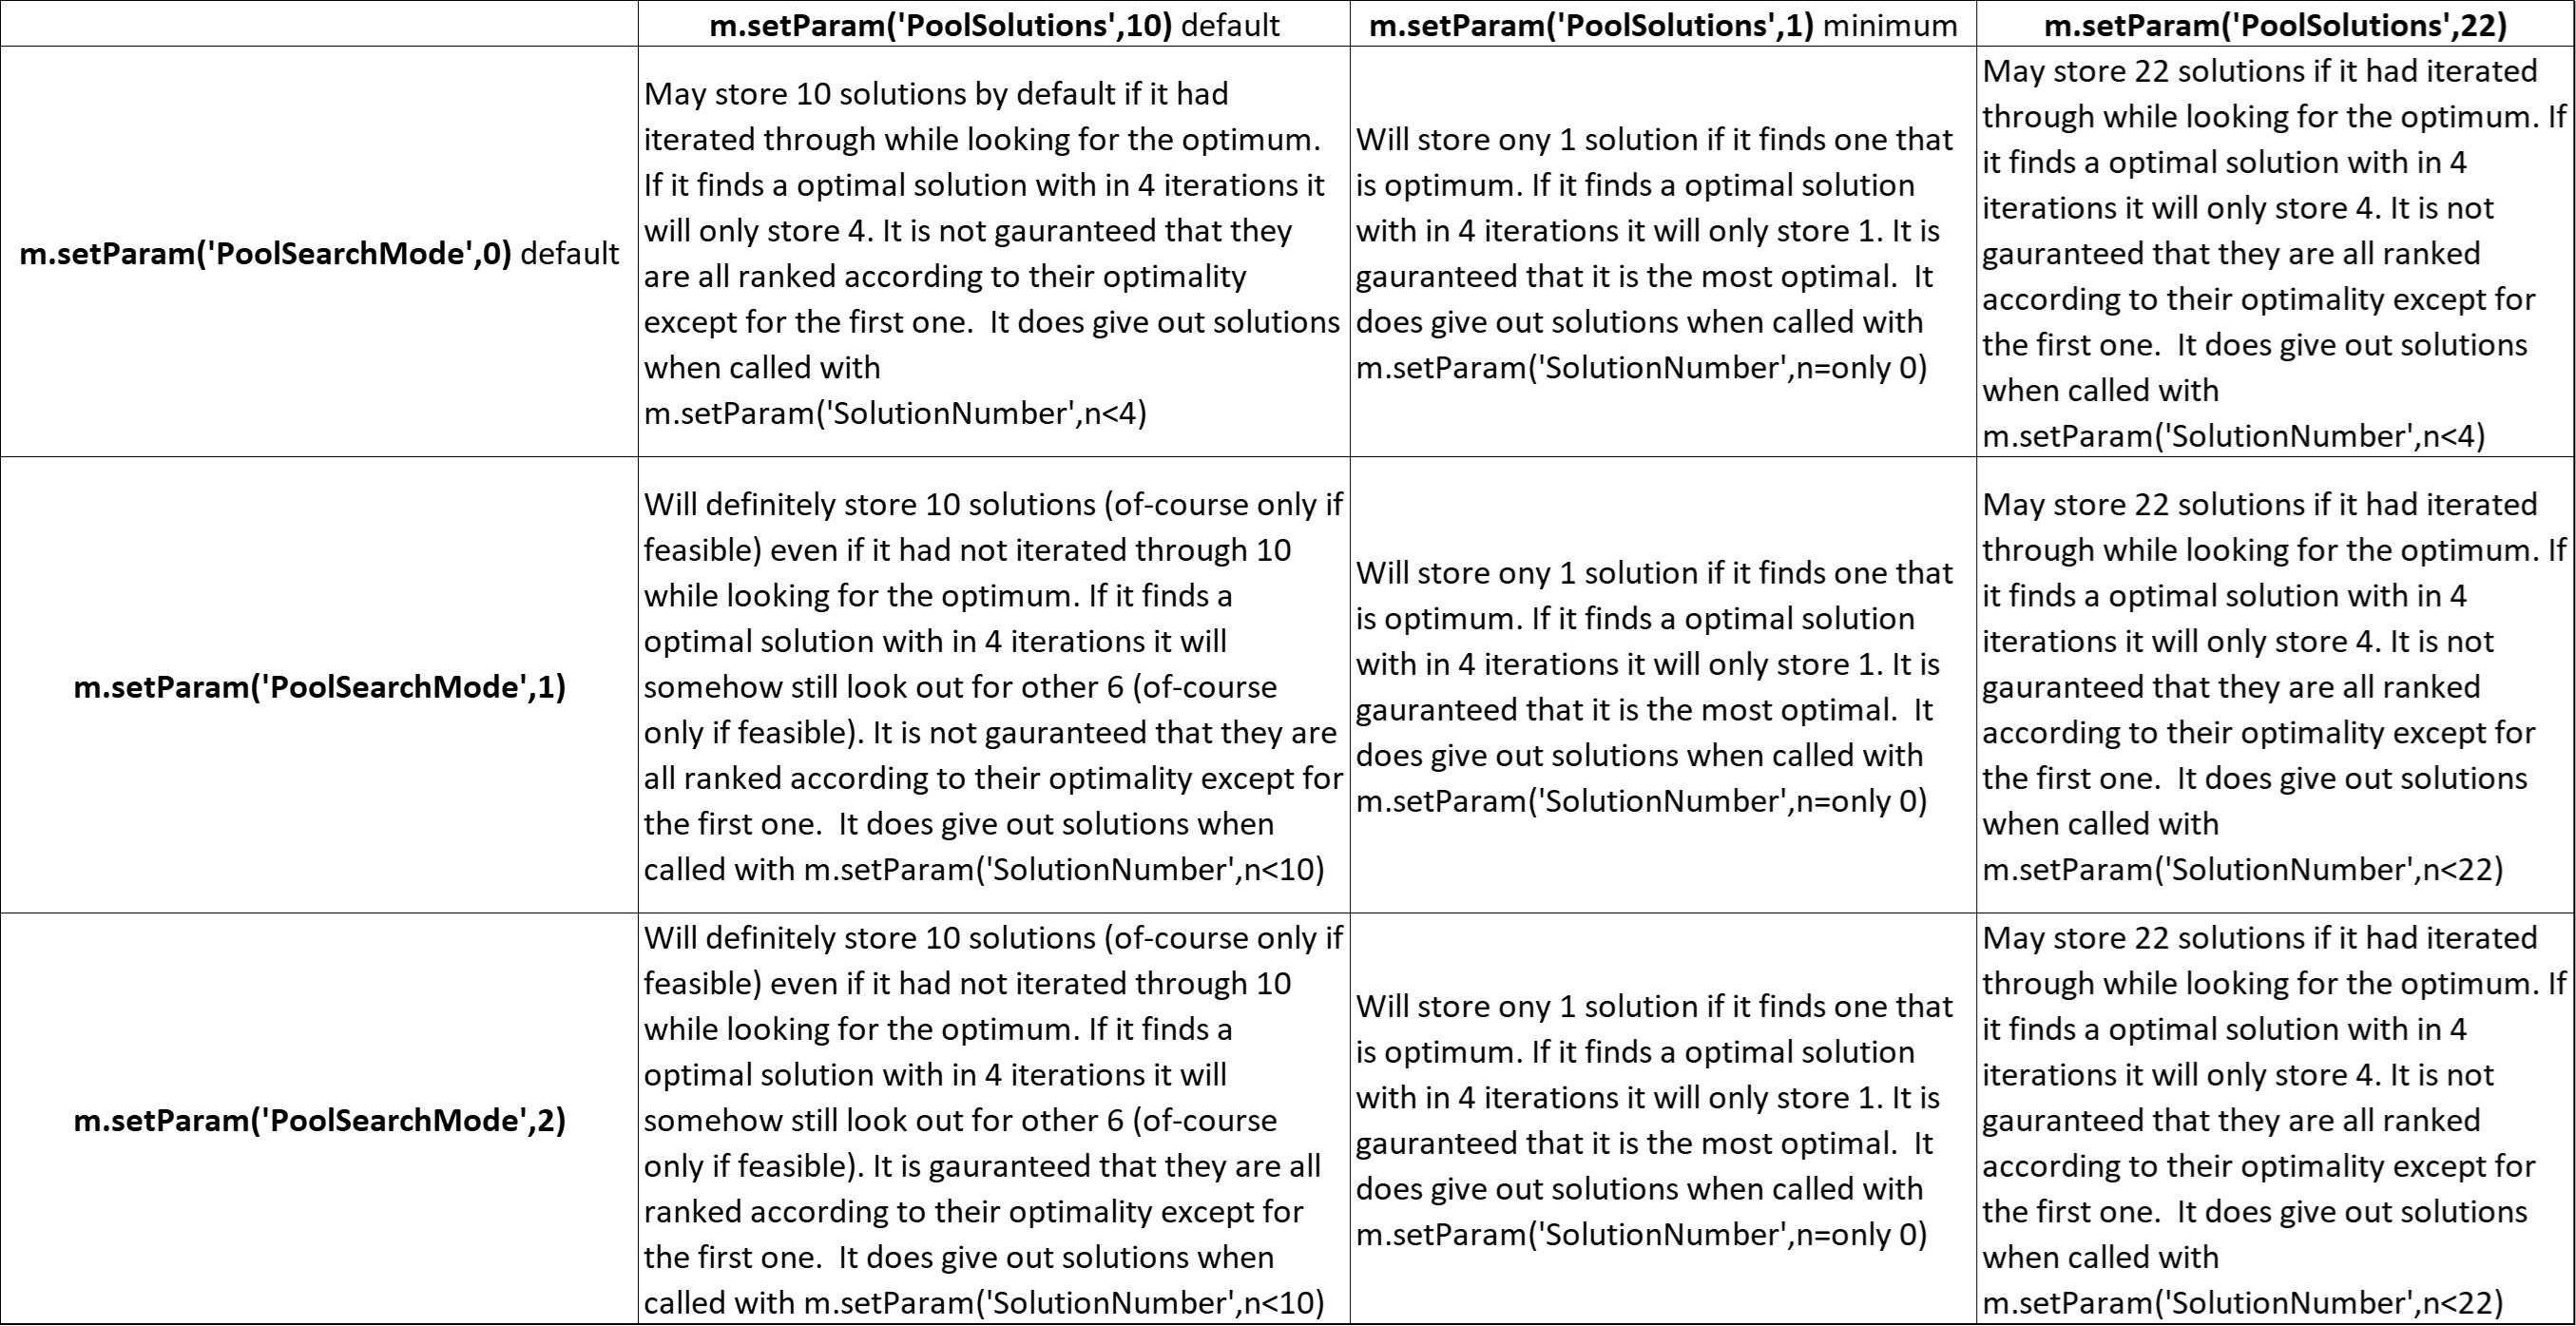

# Statistics

In [17]:
# m.computeIIS() # Dont know what exactly this is. It works only on infeasible solutions

# m.write('C:\\Users\\sabbe\\Desktop\\UPitt\\Optimization\\United_airlines_bagrunner_optimization\\model.lp')
# m.write('C:\\Users\\sabbe\\Desktop\\UPitt\\Optimization\\United_airlines_bagrunner_optimization\\model.mps')
# print (m.display())

In [18]:
# m.printQuality()
# m.printStats()

# Answer check

In [19]:
#m.setParam('SolutionNumber',12250)
#m.setParam('SolutionNumber',1)

for I in set_I:
    globals()['sol%s'%I]=[]
    for K in set_K:
        globals()['sol%s'%I].append(t[K,I].xn)
    print(globals()['sol%s'%I])
    

print('---------------------------------------------------------------------')

for I in set_I:
    globals()['soll%s'%I]=[]
    for J in set_J:
        globals()['soll%s'%I].append(x[J,I].Xn)
    print(globals()['soll%s'%I])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
---------------------------------------------------------------------
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,

## Solutions in a dataset

In [20]:
sol_pool = pd.read_excel('C:\\Users\\sabbe\\Desktop\\UPitt\\Optimization\\United_airlines_bagrunner_optimization\\Solution_pool_template.xlsx',sheet_name = "Sheet1")

In [21]:
#nn = 18192
n
for r in range(0,n):
    m.setParam('SolutionNumber',r) # 0 by default
    row = r
    for K in set_K:
        string=""
        for i in set_i:
            if t[K,i].xn >= 0.5:
                string = string + str(i) + "p,"
        if string != "":
            sol_pool.at[row, 'attempt ' + str(K)] = string[:len(string)-1]
        else:
            sol_pool.at[row, 'attempt ' + str(K)] = str(int(sum(round(x[K,ii].xn)*ii for ii in set_i))) + 'd'
    la = number_of_gates*2-1
    sol_pool.at[row, 'attempt ' + str(la)] = str(int(sum(round(x[K,ii].xn)*ii for ii in set_i))) + 'd'

In [22]:
def count(s):
    c=0
    for i in range(0,len(s)):
        if s[i] == 'p':
            c = c+1
    return c

for l in range(0,len(sol_pool)):
    total_time = 0
    globals()['dict_%s'%l] = {}
    
    for K in set_K:
        if sol_pool['attempt '+str(K)].iloc[l] == "0d":
            break
        if K == 0:
            total_time = count(sol_pool['attempt '+str(K)].iloc[l])*load_time
            globals()['dict_%s'%l].update({sol_pool['attempt '+str(K)].iloc[l]:total_time})
        else:
            if "d" in sol_pool['attempt '+str(K)].iloc[l]:
                if "p" in sol_pool['attempt '+str(K-1)].iloc[l]:
                    total_time = total_time + unload_time + travel_time * int(sol_pool['attempt '+str(K)].iloc[l][:-1])
                    globals()['dict_%s'%l].update({sol_pool['attempt '+str(K)].iloc[l]:total_time})
                else:
                    total_time = total_time + unload_time + travel_time * abs( int(sol_pool['attempt '+str(K-1)].iloc[l][:-1]) - int(sol_pool['attempt '+str(K)].iloc[l][:-1])  )
                    globals()['dict_%s'%l].update({sol_pool['attempt '+str(K)].iloc[l]:total_time})
            else:
                total_time = total_time + load_time*(count(sol_pool['attempt '+str(K)].iloc[l])) + travel_time * int(sol_pool['attempt '+str(K-1)].iloc[l][:-1])
                globals()['dict_%s'%l].update({sol_pool['attempt '+str(K)].iloc[l]:total_time})
                
    sol_pool.at[l, 'total_time'] =  list(globals()['dict_%s'%l].values())[-1]/3600

In [23]:
sol_pool['sequence'] = str('')
for i in range(0,len(sol_pool)):
    for j in range(0,len(sol_pool.columns)-2):
        sol_pool['sequence'].iloc[i] = str(sol_pool['sequence'].iloc[i])+str(sol_pool.iloc[i,j])

In [24]:
sol_pool

,attempt 0,attempt 1,attempt 2,attempt 3,attempt 4,attempt 5,attempt 6,attempt 7,attempt 8,attempt 9,attempt 10,attempt 11,attempt 12,attempt 13,attempt 14,attempt 15,attempt 16,attempt 17,total_time,sequence
0,"2p,5p,8p,9p",2d,8d,"6p,7p",9d,7d,5d,"1p,3p",3d,1d,6d,4p,4d,0d,0d,0d,0d,0d,3.300000,"2p,5p,8p,9p2d8d6p,7p9d7d5d1p,3p3d1d6d4p4d0d0d0..."
1,"1p,4p,8p",1d,5p,4d,"3p,9p",8d,9d,2p,3d,5d,2d,6p,6d,7p,7d,0d,0d,0d,3.400000,"1p,4p,8p1d5p4d3p,9p8d9d2p3d5d2d6p6d7p7d0d0d0d"
2,"5p,7p,9p",9d,7d,"3p,4p,6p",6d,4d,3d,"1p,2p,8p",1d,2d,8d,5d,0d,0d,0d,0d,0d,0d,2.866667,"5p,7p,9p9d7d3p,4p,6p6d4d3d1p,2p,8p1d2d8d5d0d0d..."
3,"2p,8p",8d,"3p,5p",2d,4p,4d,5d,1p,3d,7p,7d,"6p,9p",6d,9d,1d,0d,0d,0d,3.733333,"2p,8p8d3p,5p2d4p4d5d1p3d7p7d6p,9p6d9d1d0d0d0d"
4,"1p,4p,7p,8p",1d,4d,7d,"3p,9p",8d,9d,"2p,5p",3d,5d,2d,6p,6d,0d,0d,0d,0d,0d,3.100000,"1p,4p,7p,8p1d4d7d3p,9p8d9d2p,5p3d5d2d6p6d0d0d0..."
5,"1p,2p,7p",1d,4p,2d,6p,6d,7d,"3p,9p",9d,4d,5p,5d,3d,8p,8d,0d,0d,0d,3.366667,"1p,2p,7p1d4p2d6p6d7d3p,9p9d4d5p5d3d8p8d0d0d0d"
6,"1p,4p,8p",8d,5p,4d,"3p,9p",1d,9d,2p,3d,5d,2d,6p,6d,7p,7d,0d,0d,0d,3.866667,"1p,4p,8p8d5p4d3p,9p1d9d2p3d5d2d6p6d7p7d0d0d0d"
7,"1p,4p,5p,8p",1d,5d,8d,"6p,7p,9p",9d,6d,"2p,3p",7d,2d,3d,4d,0d,0d,0d,0d,0d,0d,3.100000,"1p,4p,5p,8p1d5d8d6p,7p,9p9d6d2p,3p7d2d3d4d0d0d..."
8,"1p,3p,4p,9p",4d,5p,9d,8p,8d,3d,2p,2d,6p,5d,1d,6d,7p,7d,0d,0d,0d,3.933333,"1p,3p,4p,9p4d5p9d8p8d3d2p2d6p5d1d6d7p7d0d0d0d"
9,"1p,4p,6p,8p",6d,5p,4d,3p,8d,3d,2p,2d,9p,5d,1d,9d,7p,7d,0d,0d,0d,3.933333,"1p,4p,6p,8p6d5p4d3p8d3d2p2d9p5d1d9d7p7d0d0d0d"


## Checking for duplicates

In [25]:
for i in range(0,len(sol_pool)):
    if sol_pool["sequence"].duplicated()[i] == True:
        print(sol_pool["sequence"].duplicated()[i])

## Solution pool export
### Block code with error

In [26]:
print(Code intentionally blocked here)

writer = pd.ExcelWriter('Solution.xlsx')
sol_pool.to_excel(writer, 'Solution', na_rep='NA')
writer.save()

SyntaxError: invalid syntax (Temp/ipykernel_9484/3641060880.py, line 1)